# Demonstration using NEURON + Python

This jupyter notebook requires a valid installation of [NEURON](https://github.com/nrnhines/nrn) with python configured. 

### 1. Download a neuron morphology and electrical model from ModelDB


This model is open source and provided by the Allen Brain Institute

In [1]:
import httplib
import requests
import shutil

def modeldb_download(model_id, fileobj):
    """Download model from ModelDB in ZIP format
    """
    dl_url_prefix = "https://senselab.med.yale.edu/modeldb/eavBinDown.cshtml?"
    dl_url = dl_url_prefix + "o={model_id}&a=311&mime=application/zip"
    resp = requests.get(dl_url.format(model_id=model_id), stream=True)
    resp.raise_for_status()
    if resp.status_code == httplib.OK:
        resp.raw.decode_content = True
        shutil.copyfileobj(resp.raw, fileobj)

In [2]:
# Download Allen Cell Types Database model in ./models directory
import os
try:
    os.makedirs('/opt/src/models')
except OSError:
    pass
with open('/opt/src/models/184167.zip', 'wb') as ostr:
    modeldb_download(184167, ostr)

In [3]:
! cd /opt/src/models ; unzip 184167

Archive:  184167.zip
   creating: 472300877converted/
  inflating: 472300877converted/readme.html  
   creating: 472300877converted/modfiles/
  inflating: 472300877converted/modfiles/Im.mod  
  inflating: 472300877converted/modfiles/NaTa.mod  
  inflating: 472300877converted/modfiles/K_P.mod  
  inflating: 472300877converted/modfiles/Ca_HVA.mod  
  inflating: 472300877converted/modfiles/NaTs.mod  
  inflating: 472300877converted/modfiles/Kv3_1.mod  
  inflating: 472300877converted/modfiles/K_T.mod  
  inflating: 472300877converted/modfiles/Im_v2.mod  
  inflating: 472300877converted/modfiles/Ca_LVA.mod  
  inflating: 472300877converted/modfiles/Kv2like.mod  
  inflating: 472300877converted/modfiles/NaV.mod  
  inflating: 472300877converted/modfiles/SK.mod  
  inflating: 472300877converted/modfiles/Kd.mod  
  inflating: 472300877converted/modfiles/Nap.mod  
  inflating: 472300877converted/modfiles/Ih.mod  
  inflating: 472300877converted/modfiles/CaDynamics.mod  
  inflating: 472300877c

In [4]:
! rm -rf /opt/src/models/AllenBrainNeuron ; mv /opt/src/models/472300877converted /opt/src/models/AllenBrainNeuron


### 2. Download our special synapse model

This model is very likely open source. Anyways, use with care. 

#### To download the model, replace `<user>` below with your username 

In [5]:
! git clone -q \
  ssh://$USER_LOGIN@bbpcode.epfl.ch/sim/neurodamus/bbp /opt/src/neurodamus


Total 16285 (delta 10349), reused 16185 (delta 10349)


In [6]:
! cp /opt/src/neurodamus/lib/modlib/ProbAMPANMDA_EMS.mod /opt/src/models/AllenBrainNeuron/modfiles

In [7]:
os.chdir('/opt/src/models/AllenBrainNeuron')

### 3. Generate ion channel and synapse C files for NEURON

In [8]:
! nrnivmodl modfiles

Creating x86_64 directory for .o files.

/opt/src/models/AllenBrainNeuron
ls: cannot access 'modfiles/*.inc': No such file or directory
modfiles/CaDynamics.mod modfiles/Ca_HVA.mod modfiles/Ca_LVA.mod modfiles/Ih.mod modfiles/Im.mod modfiles/Im_v2.mod modfiles/Kd.mod modfiles/K_P.mod modfiles/K_T.mod modfiles/Kv2like.mod modfiles/Kv3_1.mod modfiles/Nap.mod modfiles/NaTa.mod modfiles/NaTs.mod modfiles/NaV.mod modfiles/ProbAMPANMDA_EMS.mod modfiles/SK.mod
CaDynamics.mod Ca_HVA.mod Ca_LVA.mod Ih.mod Im.mod Im_v2.mod Kd.mod K_P.mod K_T.mod Kv2like.mod Kv3_1.mod Nap.mod NaTa.mod NaTs.mod NaV.mod ProbAMPANMDA_EMS.mod SK.mod
"/opt/nrn/x86_64/bin/nocmodl" CaDynamics
Translating CaDynamics.mod into CaDynamics.c
Thread Safe
"/opt/nrn/share/nrn/libtool"  --mode=compile gcc -DHAVE_CONFIG_H  -I. -I.. -I"/opt/nrn/include/nrn" -I"/opt/nrn/x86_64/lib"      -g -O2 -c -o CaDynamics.lo CaDynamics.c
libtool: compile:  gcc -DHAVE_CONFIG_H -I. -I.. -I/opt/nrn/include/nrn -I/opt/nrn/x86_64/lib -g -O2 -c CaDyn

### 4. Definition of simulation parameters

In [9]:
import neuron
from neuron import h,gui
import matplotlib.pyplot as plt
import sys
import numpy as np

%matplotlib inline


In [10]:
sys.path.append(os.getcwd())
from neuron472300877 import Neuron472300877 as Cell

In [11]:
junction_potential = -14.0
h.tstop = 550
h.celsius = 34.0

In [12]:
cell = Cell()

In [13]:
# setup recording
n_rec = 1
t = h.Vector()
t.record(h._ref_t)
rec_vec = []
for i in range(n_rec):
    rec_vec.append( h.Vector() )
    rec_vec[-1].record(cell.soma[i](0.5)._ref_v)

### 5. Place some synapses at random dendritic locations

In [14]:
synlist = []
NSYN = 10

In [15]:
for i in range(NSYN):
    target = np.random.randint(len(cell.dend))
    synlist.append( h.ProbAMPANMDA_EMS(0.5, sec=cell.dend[target]) )

In [16]:
stimlist = []
NSTIM = NSYN

### 6. Define how to stimulate those synapses

In [17]:
for i in range(NSTIM):
    stim = h.NetStim()
    stim.start = np.random.normal(20.0,2.0)
    stim.noise = 1.0
    stim.interval = 100.0
    stim.number = 1e+9
    stimlist.append(stim)

In [18]:
nclist = []
w = 5.0

In [19]:
for syn, stim in zip(synlist[:-1], stimlist[:-1]):
    ncstim = h.NetCon(stim, syn)
    ncstim.delay = 1.
    ncstim.weight[0] = w
    nclist.append(ncstim)

### 7. Tell NEURON we want to record from every synapse

In [20]:
t_vec = h.Vector()
id_vec = h.Vector()
for i in range(len(nclist)):
    nclist[i].record(t_vec, id_vec, i)

### 8. Initialize simulation state

In [21]:
h.v_init = -88.734330774000796
h.init()
h.finitialize()

1.0

### 9. Simulate!

In [22]:
h.tstop = 100
h.batch_run(100., 1./h.steps_per_ms)

1.0

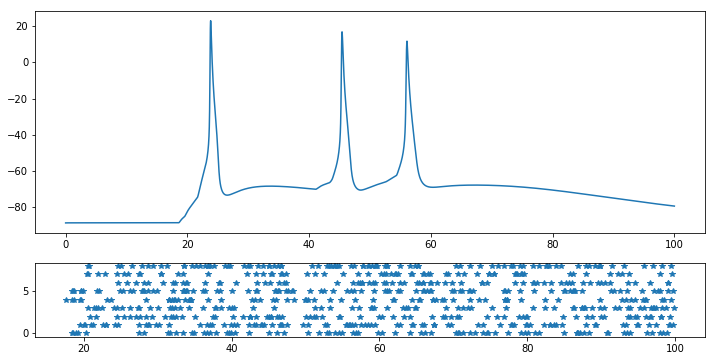

In [34]:
from matplotlib import gridspec
fig = plt.figure(figsize=(12, 6)) 
gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1]) 
ax0 = plt.subplot(gs[0])
for i in range(n_rec):
    ax0.plot(t,rec_vec[i],'-')
ax1 = plt.subplot(gs[1])
ax1.plot(t_vec.to_python(), id_vec.to_python(), '*')

### 10. Change some simulation parameters

Here we increase the frequency of stimulation of synapses

In [23]:
for i in range(NSTIM):
    stimlist[i].interval = 1.0

In [24]:
h.v_init = -88.734330774000796
h.init()
h.finitialize()

1.0

In [25]:
h.tstop = 100
h.batch_run(100., 1./h.steps_per_ms)

1.0

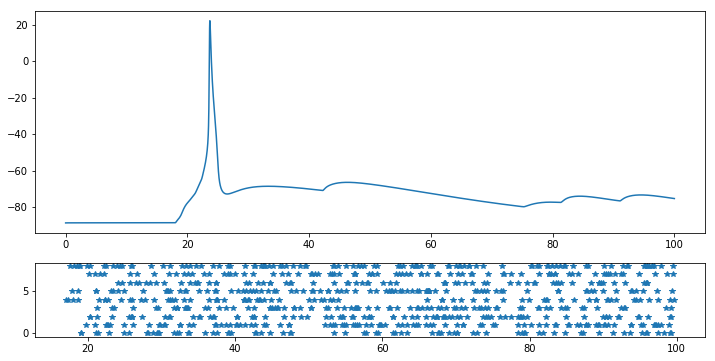

In [30]:
fig = plt.figure(figsize=(12, 6)) 
gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1]) 
ax0 = plt.subplot(gs[0])
for i in range(n_rec):
    ax0.plot(t,rec_vec[i],'-')
ax1 = plt.subplot(gs[1])
ax1.plot(t_vec.to_python(), id_vec.to_python(), '*')